### Hohmann Transfer

A simple Hohmann transfer between two orbits.

(incomplete)

In [1]:
import cusfkiwi as kiwi
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
# Earth properties
earth = {"r" : 6371e3, "mu" : 3.986004418e14}

# Initial orbit
orbit1 = {"alt" : 400e3}
orbit1["vel"] = ( earth["mu"] / (earth["r"] + orbit1["alt"]) )**0.5
orbit1["r"] = orbit1["alt"] + earth["r"]

# Target orbit
orbit2 = {"alt" : 800e3}
orbit2["vel"] = ( earth["mu"] / (earth["r"] + orbit2["alt"]) )**0.5
orbit2["r"] = orbit2["alt"] + earth["r"]

# Initiate in Orbit 1
init_state = kiwi.State(time = 0, 
                        pos = [orbit1["r"], 0, 0], 
                        vel = [0, orbit1["vel"], 0],
                        ang_pos = [0,0,0,1], 
                        ang_vel = [0, 0, 0])

In [3]:
# Orbit 1 period
period = 2 * np.pi * (orbit1["r"]**3 / earth["mu"])**0.5

# End condition at apogee
r_last = orbit1["r"]
def end_condition(state):
    global r_last
    r = np.linalg.norm(state.pos)
     
    # Propagate at least 1 orbit
    if state.time < 1.05 * period:
        r_last = r    
        return False
    
    else:
        dr = r - r_last
        if dr < 0:
            r_last = r    
            return True    # End simulation at apogee
        
        else:
            r_last = r    
            return False
        
dry_mass = 50
fuel_mass = 100
isp = 3000              # m/s of specific impulse
mdot = 0.1
start_burn_1 = period   # Start the first burn after 1 period
dt = 0.5

# Calculate the burn time iteratively
def propagate1(burn_time_1):
    
    def mass_func(t):
        if t < start_burn_1:
            return dry_mass + fuel_mass
        elif t < start_burn_1 + burn_time_1:
            return dry_mass + fuel_mass - mdot * (t - start_burn_1)
        else:
            return dry_mass + fuel_mass - mdot * burn_time_1
    
    def thrust_func(state):
        if state.time > start_burn_1 and state.time < start_burn_1 + burn_time_1:
            prograde = np.array(state.vel) / np.linalg.norm(state.vel)
            return mdot * isp * prograde
        else:
            return [0,0,0]
    
    def gravity_func(state):
        r = np.linalg.norm(state.pos)
        radial = np.array(state.pos) / r
        
        return - radial * earth["mu"] * mass_func(state.time) / r**2
    
    mass = kiwi.Mass(mass_func, 'time')
    moments_of_inertia = kiwi.MomentsOfInertia([1,1,1], 'none') # Not modelling rotation
    thrust = kiwi.Force(thrust_func, "state")
    gravity = kiwi.Force(gravity_func, "state")
    forces = [thrust, gravity]
    moments = []                                                # Not modelling rotation
    
    satellite = kiwi.Body(init_state, mass, moments_of_inertia, forces, moments)
    simulation = kiwi.Simulation(satellite, dt = dt, end_condition = end_condition)
    simulation.run(debug = False)
    
    return simulation
    

In [7]:
def apogee_error(burn_time_1):
    result = propagate1(burn_time_1)
    apogee = max(np.linalg.norm(state.pos) for state in result.states)
    
    error = (apogee - orbit2["r"])/1e3
    print(f"burn time = {burn_time_1:.5f} s, error = {error} km")
    return error
    
sol1 = scipy.optimize.root_scalar(apogee_error, x0 = 5, bracket = [0, 0.5*fuel_mass/mdot], xtol = dt) # Note we can't resolve burn time more accurately than the integrator timestep

burn_time_1 = sol1.root
result1 = propagate1(burn_time_1) 

burn time = 0.00000 s, error = -399.99999999999255 km
burn time = 500.00000 s, error = 6579.396201716921 km
burn time = 28.65577 s, error = -191.72687827108427 km
burn time = 54.28805 s, error = 3.9771844336958604 km
burn time = 53.76714 s, error = 0.04013477108348161 km
burn time = 53.51714 s, error = -1.2713059426257387 km


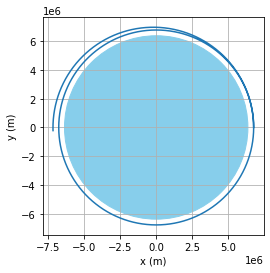

In [8]:
fig, ax = plt.subplots()
ax.plot(result1.x(), result1.y())
earth_circle = plt.Circle((0, 0), earth["r"], color='skyblue')
ax.add_patch(earth_circle)
ax.set_aspect(1)
plt.grid()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

*[everything below is incomplete]*

In [ ]:
# Now burn until perigee increases to that of orbit 2
fuel_mass = fuel_mass - burn_time_1 * mdot
start_burn_2 = 0

# Initiate at end of Orbit 1
init_state = kiwi.State(time = 0, 
                        pos = result1.states[-1].pos, 
                        vel = result1.states[-1].vel,
                        ang_pos = [0,0,0,1], 
                        ang_vel = [0, 0, 0])

# Calculate the burn time iteratively
def propagate2(burn_time_2):

    def mass_func(t):
        if t < start_burn_2:
            return dry_mass + fuel_mass
        elif t < start_burn_2 + burn_time_1:
            return dry_mass + fuel_mass - mdot * (t - start_burn_1)
        else:
            return dry_mass + fuel_mass - mdot * burn_time_1
    
    def thrust_func(state):
        if state.time > start_burn_1 and state.time < start_burn_1 + burn_time_1:
            prograde = np.array(state.vel) / np.linalg.norm(state.vel)
            return mdot * isp * prograde
        else:
            return [0,0,0]
    
    def gravity_func(state):
        r = np.linalg.norm(state.pos)
        radial = np.array(state.pos) / r
        
        return - radial * earth["mu"] * mass_func(state.time) / r**2
    
    mass = kiwi.Mass(mass_func, 'time')
    moments_of_inertia = kiwi.MomentsOfInertia([1,1,1], 'none') # Not modelling rotation
    thrust = kiwi.Force(thrust_func, "state")
    gravity = kiwi.Force(gravity_func, "state")
    forces = [thrust, gravity]
    moments = []                                                # Not modelling rotation
    
    satellite = kiwi.Body(init_state, mass, moments_of_inertia, forces, moments)
    simulation = kiwi.Simulation(satellite, dt = dt, end_condition = end_condition)
    simulation.run(debug = False)
    
    return simulation